# reference

Theory:
https://smartbridge.com/market-basket-analysis-101/
https://www.albionresearch.com/data_mining/market_basket.php
https://docplayer.net/49837678-Apriori-algorithm-professor-anita-wasilewska-book-slides.html
https://www-users.cs.umn.edu/~kumar001/dmbook/index.php

Coding Tutorial:
https://pbpython.com/market-basket-analysis.html
https://towardsdatascience.com/a-gentle-introduction-on-market-basket-analysis-association-rules-fa4b986a40ce
https://www.datacamp.com/community/tutorials/market-basket-analysis-r#apriori

Apriori package:
http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/
http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/
http://rasbt.github.io/mlxtend/user_guide/preprocessing/TransactionEncoder/

Data:
http://archive.ics.uci.edu/ml/datasets/Online+Retail
http://archive.ics.uci.edu/ml/machine-learning-databases/00352/

Daqing Chen, Sai Liang Sain, and Kun Guo, Data mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining, Journal of Database Marketing and Customer Strategy Management, Vol. 19, No. 3, pp. 197â€“208, 2012 (Published online before print: 27 August 2012. doi: 10.1057/dbm.2012.17).
   

In [62]:
from datetime import datetime
from typing import List, Dict
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder


# Read the data

In [63]:
# data is available here: http://archive.ics.uci.edu/ml/datasets/online+retail

path = r"D:\OneDrive - insidemedia.net\project\data-science-project\market-basket-analysis\data"
data_name = 'Online Retail.csv'

df_original = pd.read_csv(path + '/' + data_name)

# Overview the data


In [100]:
print('shape of the data is', df_original.shape)
df_original.head(3)

shape of the data is (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom


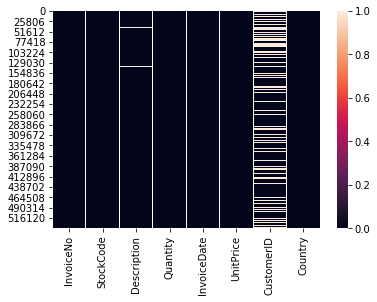

In [65]:
# Show the missing values
sns.heatmap(df_original.isnull())
plt.show()

# column 'customerID' is missing a lot of data. I think it is normal because if you buy online without registration,
# the system will not have your ID

# Clean the data

### Calculate the percentage of the missing data in each column


In [66]:
def missing_percent(df: pd.DataFrame) -> Dict:
    """Calculate the percentage of the missing data in each columns"""
    percent = {}
    for column_name in list(df.columns):
        percent[column_name] = sum(df[column_name].isnull()) / len(df[column_name])
    return percent

In [102]:
percent = missing_percent(df_original)
percent

# 25% of the rows have no customer ID.

{'InvoiceNo': 0.0,
 'StockCode': 0.0,
 'Description': 0.002683107311375157,
 'Quantity': 0.0,
 'InvoiceDate': 0.0,
 'UnitPrice': 0.0,
 'CustomerID': 0.249266943342886,
 'Country': 0.0}

### Drop some rows that have missing value in some columns

In [103]:
def dropna_rows(df: pd.DataFrame, columns: List) -> pd.DataFrame:
    """ 
    Drop the missing rows given the selected columns
    If those columns have any missing data in some rows, need to exclude those rows.
    """
    df_drop = df.dropna(axis=0, how='any', subset=columns)
    return df_drop

In [104]:
# The description, invoice number, quantity cannot be empty. If any of them is empty, there might be something wrong in the 
# system, those rows will be deleted
columns = ['Description', 'Quantity', 'InvoiceNo']

df = dropna_rows(df_original, columns)
print(df.shape)

(540455, 8)


### Check the percentage of the missing value again


In [105]:
percent = missing_percent(df)
percent

# Only CustomerID column has missing value now. Leave it as it is.

{'InvoiceNo': 0.0,
 'StockCode': 0.0,
 'Description': 0.0,
 'Quantity': 0.0,
 'InvoiceDate': 0.0,
 'UnitPrice': 0.0,
 'CustomerID': 0.24724722687365275,
 'Country': 0.0}

### Check the rows that have negative quantity 


In [106]:
nagative_quantity = df[df.Quantity <= 0]
nagative_quantity.head(3)

# Negative quantity is corresponding to the cancelled order. we need to remove them.

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom


In [72]:
# Select the positive quantity
df = df[df.Quantity > 0]

### check the canceled orders.


In [73]:
cancel_order = df[(df['InvoiceNo'].astype(str).str.contains('c|C', regex=True))]
cancel_order.head(10)

# In fact, all the cancel orders have been removed because I only select the positive quantity in the
# previous step

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


### Some of the product description have extra space, better to remove them


In [74]:
df['Description'] = df.Description.str.strip()
df['Description'] = df.Description.apply(lambda s: re.sub(' +', ' ', s))


### In part of the data, there are more than two product in one row, remove them

In [107]:
# for example
df[df.Description.str.contains('SUGAR')].head(3)

# this doesn't make any sense because because the data is supposed to contain only one product per row. 
# If there are two product per row, what does the UnitPrice stands for? 
# Check InvoiceNo 536544 and 536638. They have the same products but have different UnitPrice.Strange? 
# Thus, I remove those rows for now.


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1922,536544,21216,"SET 3 RETROSPOT TEA,COFFEE,SUGAR",1,12/1/2010 14:32,11.02,NaN,United Kingdom
3619,536638,21216,"SET 3 RETROSPOT TEA,COFFEE,SUGAR",4,12/2/2010 11:41,4.95,16244.0,United Kingdom
3929,536739,85159A,"BLACK TEA,COFFEE,SUGAR JARS",2,12/2/2010 13:08,6.35,14180.0,United Kingdom


In [76]:
def remove_comma_end(s):
    """ Remove the comma at the end of the description"""
    if s.rfind(',') == len(s)-1:
        s = s[:-1]
        
    return s

# If there is a comman at the end of the product description, remove it
df['Description'] = df.Description.apply(remove_comma_end)


In [108]:
# There are 2 or more product if there is 1 or more comma in the middle of the description
num_items_per_row = df.Description.str.split(',').apply(lambda x: len(x))

# Return the row index that have more than 2 items per row
list1 = list(num_items_per_row[num_items_per_row >= 2].index)

# pick up the rows that have more than two items
df_more_than_one_product_in_a_row = df[df.index.isin(list1)]
print(df_more_than_one_product_in_a_row.Description.head(5))

ratio = df_more_than_one_product_in_a_row.shape[0] / df.shape[0]
print('\n The number of rows that have more than two products in a row in the data is', df_more_than_one_product_in_a_row.shape[0],
      ', the proportion to the total number of rows is', ratio)

109              AIRLINE LOUNGE,METAL SIGN
253             FANCY FONT BIRTHDAY CARD, 
956                 TRAY, BREAKFAST IN BED
1014    SWISS ROLL TOWEL, CHOCOLATE  SPOTS
1083    SWISS ROLL TOWEL, CHOCOLATE  SPOTS
Name: Description, dtype: object

 The number of rows that have more than two product in a row in the data is 4796 , the proportion to the total number of rows is 0.008874004311182244


In [78]:
# Remove those rows

df  = df[~df.index.isin(list1)]


print('After clean the data, the shape of the data is', df.shape)

After clean the data, the shape of the data is (526445, 8)


# Analyze the data

## Process the data

In [79]:
def get_percentage(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
    """ In the column you specify, calculate the proportion of each row to the sum of that column """
    new_column_name = column_name + '_percentage'
    df[new_column_name] = df[column_name] / df[column_name].sum()
    df[new_column_name] = df[new_column_name].map('{: .2%}'.format)
    return df

In [80]:
# Add a column for sales
df['Sales'] = df.Quantity * df.UnitPrice
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00


In [81]:
# Transform to the proper datetime format that Pandas use
df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate, infer_datetime_format=True)


In [82]:
df.shape

(526445, 9)

## (1) Analyze the product

### (1.1) Sales by product


                                        Sales Sales_percentage
Description                                                   
dotcom postage                      206248.77            1.98%
regency cakestand 3 tier            174484.74            1.67%
white hanging heart t-light holder  106292.77            1.02%
party bunting                        99504.33            0.95%
jumbo bag red retrospot              94340.05            0.90%
medium ceramic top storage jar       81700.92            0.78%
manual                               78112.82            0.75%
postage                              78101.88            0.75%
rabbit night light                   66964.99            0.64%
paper chain kit 50's christmas       64952.29            0.62%


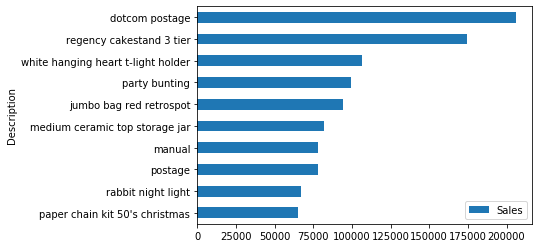

In [83]:
df_product_sales = df.groupby(by='Description').agg({'Sales': np.sum}).sort_values(by='Sales', ascending=False)

# convert the product name to lower case
df_product_sales.set_index(df_product_sales.index.str.lower(), inplace=True) 
df_product_sales = get_percentage(df_product_sales, 'Sales')

df_print = df_product_sales.head(10)
print(df_print)

df_plot = df_print[::-1]
ax = df_plot.plot.barh()

# The top sale is dotcom postage. Since we only analyze the product sales right now, I don't want to include postage in our analysis.

In [84]:
df = df[~df.Description.str.lower().str.contains('dotcom postage')]

### (1.2) number of unique customer buy the  product 

Description
regency cakestand 3 tier              881
white hanging heart t-light holder    856
party bunting                         708
assorted colour bird ornament         678
set of 3 cake tins pantry design      640
jumbo bag red retrospot               635
pack of 72 retrospot cake cases       635
paper chain kit 50's christmas        613
natural slate heart chalkboard        587
baking set 9 piece retrospot          581
dtype: int64


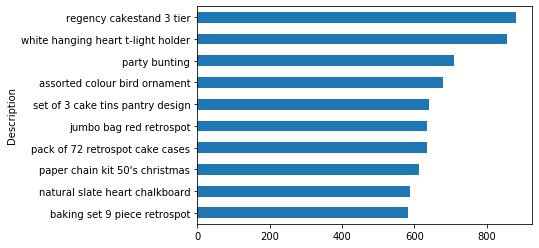

In [85]:
df_product_customer = df.groupby(by='Description').apply(lambda x: x['CustomerID'].nunique()).sort_values(ascending=False)

# convert the product name to lower case
df_product_customer.index = df_product_customer.index.str.lower() 

df_print = df_product_customer.head(10)
print(df_print)

df_plot = df_print[::-1]
ax = df_plot.plot.barh()


## (2) Analyze locations

###  Sales by country


                       Sales Sales_percentage
Country                                      
United Kingdom  8.593274e+06           84.03%
Netherlands     2.842255e+05            2.78%
EIRE            2.823020e+05            2.76%
Germany         2.279567e+05            2.23%
France          2.095205e+05            2.05%
Australia       1.367742e+05            1.34%
Spain           6.145555e+04            0.60%
Switzerland     5.692394e+04            0.56%
Belgium         4.103821e+04            0.40%
Sweden          3.815657e+04            0.37%


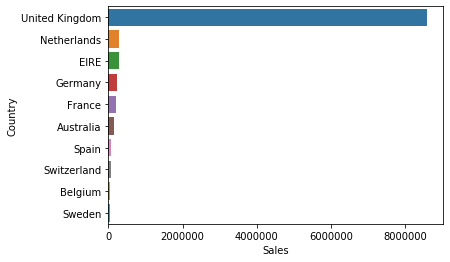

In [86]:
df_country_sales = df.groupby(by='Country').agg({'Sales': np.sum}).sort_values(by='Sales', ascending=False)
df_country_sales = get_percentage(df_country_sales, 'Sales')
print(df_country_sales.head(10))

# plot
df_plot = df_country_sales.head(10).reset_index()
sns.barplot(data=df_plot, y='Country', x='Sales')

# Since the online retail is based on UK. No surprise that majority of the sale came from UK

## (3) Time analysis

### Sales by month


Text(0, 0.5, 'Sales')

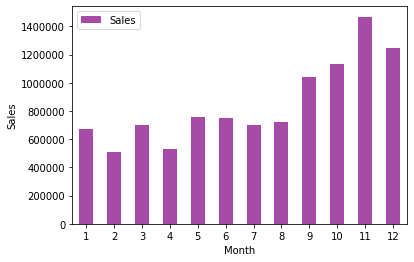

In [87]:
fig = plt.figure(figsize=(6,4))
axes = fig.add_subplot(1, 1, 1)

df_hour_sales = df.groupby(by=df.InvoiceDate.dt.month).agg({'Sales': np.sum})
df_hour_sales.index.name = 'Month'
df_hour_sales.plot.bar(ax=axes, rot=0, color='purple', alpha=0.7)
axes.set_ylabel('Sales')

# the top sales is in November and december. This is resonable as people prepare the chrismas season

## (4) customer analysis

### the distribution of how much customer spend


Text(0.5, 0, 'Spend')

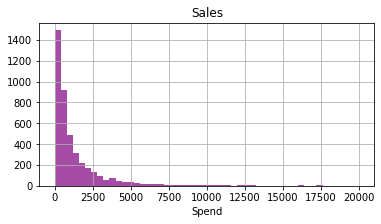

In [88]:
fig, axes = plt.subplots(1, 1, figsize=(6, 3))

df.groupby(by='CustomerID').agg({'Sales':np.sum}).hist(ax=axes, bins=50, range=(0,20000), color='purple', alpha=0.7)
axes.set_xlabel('Spend')

# the distribution is right skewed

# Transform the data to the format that the package needs

In [89]:
# Transform the data into the correct format required by the algorithm.
# For the same InvoiceNo and product, sum up their quantity.

basket = (df.pivot_table(index='InvoiceNo',columns='Description', values='Quantity', aggfunc=np.sum, fill_value=0)
          .reset_index().set_index('InvoiceNo'))

basket.head(10)



Description,*Boombox Ipod Classic,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,...,returned,taig adjust,test,to push order througha s stock was,website fixed,wrongly coded 20713,wrongly coded 23343,wrongly marked,wrongly marked 23343,wrongly sold (22719) barcode
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536370,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536371,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536372,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536373,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
print(basket.shape)

# before we pivot the table, one transaction may contains several rows if there are multiple products in the same transaction.
# After we pivot the table, each row contains only one transaction, with the colum names corresponding to unique products within
# that transaction.
# 
#There are 3990 different products.

(20127, 3990)


In [91]:
# In order to use the apriori algorithm, need to specify each element either 1(true) or 0(false). 

basket_sets = basket.where(basket == 0, 1 )
basket_sets.head(10)

Description,*Boombox Ipod Classic,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,...,returned,taig adjust,test,to push order througha s stock was,website fixed,wrongly coded 20713,wrongly coded 23343,wrongly marked,wrongly marked 23343,wrongly sold (22719) barcode
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536370,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536371,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536372,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536373,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Apply the apriori algorithm
The format of using this package is: 
apriori(df, min_support=0.5, use_colnames=False, max_len=None)




## 1. Generate frequent itemsets

In [92]:
frequent_itemsets = apriori(basket_sets, min_support=0.01, use_colnames=True, max_len=None).sort_values(
    by='support',ascending=False)

In [109]:
# Filtering result you want

# Add an extra column indicate the length of the products
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

frequent_itemsets_filter = frequent_itemsets[ (frequent_itemsets['length'] == 1) & (frequent_itemsets['support'] >= 0.05) ]
frequent_itemsets_filter.head(5)



,support,itemsets,length
763,0.112287,(WHITE HANGING HEART T-LIGHT HOLDER),1
336,0.103940,(JUMBO BAG RED RETROSPOT),1
543,0.098822,(REGENCY CAKESTAND 3 TIER),1
450,0.083768,(PARTY BUNTING),1
373,0.077707,(LUNCH BAG RED RETROSPOT),1


In [110]:
frequent_itemsets_filter = frequent_itemsets[(frequent_itemsets['length'] == 2) & (frequent_itemsets['support'] >= 0.01)]

frequent_itemsets_filter.head(5)

## How to interpret the above results? For example, for 'WHITE HANGING HEART T-LIGHT HOLDER', there are 11.2% of the transaction 
## contain this product.
# 4% of the transactions include 'JUMBO BAG PINK POLKADOT' and 'JUMBO BAG RED RETROSPOT'. So we say 'JUMBO BAG PINK POLKADOT' and 'JUMBO BAG RED RETROSPOT' are 
# in the same 'basket'


,support,itemsets,length
1120,0.040990,"(JUMBO BAG PINK POLKADOT, JUMBO BAG RED RETROS...",2
965,0.038158,"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",2
1163,0.035972,"(JUMBO STORAGE BAG SUKI, JUMBO BAG RED RETROSPOT)",2
1161,0.033785,"(JUMBO BAG RED RETROSPOT, JUMBO SHOPPER VINTAG...",2
1344,0.032494,"(LUNCH BAG RED RETROSPOT, LUNCH BAG SUKI DESIGN)",2


In [95]:
# We can also check the support number by specifying the product name

frequent_itemsets[frequent_itemsets['itemsets'] == {'WHITE HANGING HEART T-LIGHT HOLDER'}]


,support,itemsets,length
763,0.112287,(WHITE HANGING HEART T-LIGHT HOLDER),1


## 2. Association Rules Generation from Frequent Itemsets
association_rules(df, metric='confidence', min_threshold=0.8, support_only=False)



### Filter by confidence

In [111]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.8).sort_values(
    by='confidence',ascending=False)
rules.to_csv('rules.csv')
rules.head(3)

# We output the rows in the frequent_itemsets that have more than 80% confidence. 
# Lets intreprete the result.
# antecedent support: 0.010583 of the transactions include the combination of products: HERB MARKER THYME, HERB MARKER PARSLEY.
# consequent support: 0.011924 of the transactions include the product HERB MARKER ROSEMARY
# support: 0.010086 of the transactions include the product HERB MARKER THYME, HERB MARKER PARSLEY, and HERB MARKER ROSEMARY.
# confidence: If people purchase HERB MARKER THYME and HERB MARKER PARSLEY, how likely they will also purchase HERB MARKER ROSEMARY.
# that will be support/antecedent support = 0.010086/0.010583 = 0.953052. The programing got the right result! 
# What we can do about it if we know these information? 
# When there is a new user purchase HERB MARKER THYME and HERB MARKER PARSLEY, the system can consider recommend him buy HERB MARKER ROSEMARY as well
# because we know many people will do that based on our data. But of course, we should also consider the support threshold, 
# for HERB MARKER THYME, HERB MARKER PARSLEY, and HERB MARKER ROSEMARY, the support is 0.010086, since there are 20127 number of transctions
# 20127 * 0.01 = 201. 201 transactions contain these three products. Do you think 201 transactions are enough to make this decision? 
# this is a subject matter.

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
85,"(HERB MARKER THYME, HERB MARKER PARSLEY)",(HERB MARKER ROSEMARY),0.010583,0.011924,0.010086,0.953052,79.925293,0.009960,21.046013
25,"(REGENCY TEA PLATE ROSES, REGENCY TEA PLATE PINK)",(REGENCY TEA PLATE GREEN),0.013365,0.018930,0.012670,0.947955,50.077423,0.012417,18.850563
87,"(HERB MARKER PARSLEY, HERB MARKER ROSEMARY)",(HERB MARKER THYME),0.010682,0.011775,0.010086,0.944186,80.184104,0.009960,17.705694


### Filter by lift

In [112]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=2).sort_values(by='lift',ascending=False)
rules.head(3)

# This time, we ouput the rows which have lift higher than 2.
# Lets manually check the lift number again.
# for (HERB MARKER PARSLEY, HERB MARKER ROSEMARY) -> (HERB MARKER THYME)
# The support of HERB MARKER THYME is 0.011775. 
# the confidence of this relation is 0.944186. As explained before, if people buy (HERB MARKER PARSLEY, HERB MARKER ROSEMARY)
# 94.4% of them will also buy (HERB MARKER THYME). 
# however, if we don't know the antecedents information, only 0.011775 of the people buy (HERB MARKER THYME). That means knowing
# the information of (HERB MARKER PARSLEY, HERB MARKER ROSEMARY) give the lift of 0.944186/0.011775 = 80.184104

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2922,"(HERB MARKER PARSLEY, HERB MARKER ROSEMARY)",(HERB MARKER THYME),0.010682,0.011775,0.010086,0.944186,80.184104,0.00996,17.705694
2923,(HERB MARKER THYME),"(HERB MARKER PARSLEY, HERB MARKER ROSEMARY)",0.011775,0.010682,0.010086,0.856540,80.184104,0.00996,6.896127
2920,"(HERB MARKER THYME, HERB MARKER PARSLEY)",(HERB MARKER ROSEMARY),0.010583,0.011924,0.010086,0.953052,79.925293,0.00996,21.046013


### Filter by combination of confidence and lift

In [113]:
# output everything first

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0)
rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))

# Filter the result by combination of confidence and lift
rules_filter = rules[ (rules['antecedent_len'] >= 1) & (rules['confidence'] > 0.8) & (rules['lift'] > 2)].sort_values(
    by=['support', 'confidence', 'lift'])

rules_filter.head(3)



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
3007,"(JUMBO BAG BAROQUE BLACK WHITE, JUMBO STORAGE ...",(JUMBO BAG RED RETROSPOT),0.012173,0.103940,0.010036,0.824490,7.932364,0.008771,5.105458,3
3029,"(JAM MAKING SET PRINTED, ROSES REGENCY TEACUP ...",(GREEN REGENCY TEACUP AND SAUCER),0.011875,0.050430,0.010036,0.845188,16.759709,0.009437,6.133710,2
2981,(HERB MARKER ROSEMARY),"(HERB MARKER THYME, HERB MARKER PARSLEY)",0.011924,0.010583,0.010086,0.845833,79.925293,0.009960,6.417841,1


In [99]:
# If you want to know all the association rule of a particular product, you can manully select it.

rules_filter[rules_filter['antecedents'] == {'HERB MARKER PARSLEY'}]


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
2980,(HERB MARKER PARSLEY),"(HERB MARKER THYME, HERB MARKER ROSEMARY)",0.011825,0.010980,0.010086,0.852941,77.679398,0.009956,6.725334,1
2471,(HERB MARKER PARSLEY),(HERB MARKER BASIL),0.011825,0.012024,0.010533,0.890756,74.083686,0.010391,9.043784,1
2468,(HERB MARKER PARSLEY),(HERB MARKER MINT),0.011825,0.011924,0.010533,0.890756,74.701050,0.010392,9.044693,1
2423,(HERB MARKER PARSLEY),(HERB MARKER THYME),0.011825,0.011775,0.010583,0.894958,76.003457,0.010444,9.407900,1
2310,(HERB MARKER PARSLEY),(HERB MARKER ROSEMARY),0.011825,0.011924,0.010682,0.903361,75.758141,0.010541,10.224436,1
